In [1]:
from time import time
import hydra
from omegaconf import DictConfig, OmegaConf
import numpy as np
import torch
import pypolo
import gpytorch
from pypolo.scalers import MinMaxScaler, StandardScaler
import yaml
from PIL import Image


/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/pypolo/planners/RRTStar_package


In [2]:
class Struct(object):
    def __init__(self, d):
        for k, v in d.items():
            
            k = k.replace("-","_")
            
            #Setting default configuration
            if k == 'defaults':
                parsed_list = eval(str(v))
                
                for item in parsed_list:
                    if isinstance(item, dict):
                        for key, value in item.items():
                            if key == '_self_':
                                pass
                            elif key == 'model':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'planner':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            elif key == 'kernel':
                                with open('./configs/' + str(key) + '/' + str(value) + '.yaml') as info:
                                    args = yaml.load(info)
                                    sub_cfg = Struct(args)
                                
                                setattr(self, key.replace("/", "_").replace(" ","_"), sub_cfg)
                                
                            else:
                                setattr(self, key.replace("/", "_").replace(" ","_"), Struct(value) if isinstance(value, dict) else value)
                            
            else:
                
                #Add other struct argument
                if isinstance(k, (list, tuple)):
                    setattr(self, k, [Struct(x) if isinstance(x, dict) else x for x in v])
                else:
                    setattr(self, k, Struct(v) if isinstance(v, dict) else v)
                
            
                

with open('./configs/main.yaml') as info:
    args = yaml.load(info)
    
print(args)
cfg = Struct(args)

{'seed': 0, 'env_extent': [-11.0, 11.0, -11.0, 11.0], 'task_extent': [-10.0, 10.0, -10.0, 10.0], 'eval_grid': [30, 30], 'sensing_rate': 0.5, 'noise_scale': 1.0, 'control_rate': 10.0, 'max_lin_vel': 0.5, 'max_ang_vel': 1.0, 'goal_radius': 0.1, 'num_bezier_points': 50, 'num_train_steps': 10, 'max_num_samples': 800, 'plot_robot_interval': 10, 'defaults': [{'model': 'gpr'}, {'kernel': 'ak'}, {'planner': 'max_entropy'}, {'override hydra/hydra_logging': 'disabled'}, {'override hydra/job_logging': 'disabled'}, '_self_'], 'hydra': {'output_subdir': None, 'run': {'dir': '.'}}}


In [4]:
max_height = 0.5

cfg.env_extent = [-10.0, 10.0, -10.0, 10.0]
cfg.noise_scale = 0.03 * max_height
cfg.planner.name = "LocalRRTStar"
cfg.task_extent = cfg.env_extent #[cfg.env_extent[0] + 0.1, cfg.env_extent[1] - 0.1, cfg.env_extent[2] + 0.1, cfg.env_extent[3] - 0.1 ]
cfg.eval_grid = [50,50]

In [5]:
x_min, x_max, y_min, y_max = cfg.task_extent
num_x, num_y = cfg.eval_grid
x_grid = np.linspace(x_min, x_max, num_x)
y_grid = np.linspace(y_min, y_max, num_y)
xx, yy = np.meshgrid(x_grid, y_grid)
eval_inputs = np.column_stack((xx.flatten(), yy.flatten()))

In [6]:
eval_inputs.shape

(2500, 2)

In [8]:
for i in np.round(eval_inputs, 1).tolist():
    print(i)

[-10.0, -10.0]
[-9.6, -10.0]
[-9.2, -10.0]
[-8.8, -10.0]
[-8.4, -10.0]
[-8.0, -10.0]
[-7.6, -10.0]
[-7.1, -10.0]
[-6.7, -10.0]
[-6.3, -10.0]
[-5.9, -10.0]
[-5.5, -10.0]
[-5.1, -10.0]
[-4.7, -10.0]
[-4.3, -10.0]
[-3.9, -10.0]
[-3.5, -10.0]
[-3.1, -10.0]
[-2.7, -10.0]
[-2.2, -10.0]
[-1.8, -10.0]
[-1.4, -10.0]
[-1.0, -10.0]
[-0.6, -10.0]
[-0.2, -10.0]
[0.2, -10.0]
[0.6, -10.0]
[1.0, -10.0]
[1.4, -10.0]
[1.8, -10.0]
[2.2, -10.0]
[2.7, -10.0]
[3.1, -10.0]
[3.5, -10.0]
[3.9, -10.0]
[4.3, -10.0]
[4.7, -10.0]
[5.1, -10.0]
[5.5, -10.0]
[5.9, -10.0]
[6.3, -10.0]
[6.7, -10.0]
[7.1, -10.0]
[7.6, -10.0]
[8.0, -10.0]
[8.4, -10.0]
[8.8, -10.0]
[9.2, -10.0]
[9.6, -10.0]
[10.0, -10.0]
[-10.0, -9.6]
[-9.6, -9.6]
[-9.2, -9.6]
[-8.8, -9.6]
[-8.4, -9.6]
[-8.0, -9.6]
[-7.6, -9.6]
[-7.1, -9.6]
[-6.7, -9.6]
[-6.3, -9.6]
[-5.9, -9.6]
[-5.5, -9.6]
[-5.1, -9.6]
[-4.7, -9.6]
[-4.3, -9.6]
[-3.9, -9.6]
[-3.5, -9.6]
[-3.1, -9.6]
[-2.7, -9.6]
[-2.2, -9.6]
[-1.8, -9.6]
[-1.4, -9.6]
[-1.0, -9.6]
[-0.6, -9.6]
[-0.2, -9.

In [6]:
# x_min, x_max, y_min, y_max = cfg.task_extent
# num_x, num_y = 200, 200#cfg.eval_grid
# x_grid = np.linspace(x_min, x_max, num_x)
# y_grid = np.linspace(y_min, y_max, num_y)
# xx, yy = np.meshgrid(x_grid, y_grid)
# all_env_points = np.column_stack((xx.flatten(), yy.flatten()))

### Testing sensor

In [38]:

def get_environment_from_image(cfg, png_path, resize=None, max_height=None):
    
    image = Image.open(png_path)
    image = image.transpose(Image.FLIP_TOP_BOTTOM)

    if resize is not None:
        if not isinstance(resize, tuple):
            raise TypeError
        else:
            resized_image = image.resize(resize, Image.BOX)
            image = resized_image.convert('L') 
    
    env = np.array(image)
    
    if max_height is not None:
        
        if not isinstance(max_height, float):
            raise TypeError
        else:
            min_value = np.min(env)
            max_value = np.max(env)
            normalized_matrix = (env - min_value) / (max_value - min_value)
            env = normalized_matrix * max_height
            
    print(f"Loaded environment of shape {env.shape}.")
    return env


env_path = '/home/kmuenpra/git/Lantao_Liu/elevation_mapping_with_ak/raw_data/terrains/n17e102.png'

env = get_environment_from_image(cfg, png_path=env_path, resize=(50,50), max_height=max_height)

rng = np.random.RandomState(cfg.seed)

#Pilot Survey
sensor = pypolo.sensors.LidarSensor(
        matrix=env,
        env_extent=cfg.env_extent,
        rate=cfg.sensing_rate,
        noise_scale=cfg.noise_scale,
        rng=rng,
        max_distance = 3, #https://community.robotshop.com/blog/show/lidar-light-amp-laser-based-distance-sensors
        perception_angle=90,
    )

Loaded environment of shape (50, 50).


In [39]:
model = 0

x_at_start, y_at_start, _ = sensor.sense( model, [-9, 8], np.deg2rad(8), ray_tracing = True, num_targets = 10)

In [40]:
x_at_start, y_at_start

(array([[-8.65029538,  7.9847183 ],
        [-6.53408235,  8.27429872],
        [-6.57122299,  8.11343138],
        [-8.08747689,  8.52718005],
        [-7.85713589,  7.89333897],
        [-6.60546653,  7.90217528],
        [-6.75638419,  7.16401736],
        [-8.85136264,  8.04265452],
        [-6.36419194,  8.94990868]]),
 array([[0.23709071],
        [0.08080551],
        [0.08948422],
        [0.37416458],
        [0.26817085],
        [0.07195501],
        [0.15598361],
        [0.4268635 ],
        [0.10475093]]))

In [41]:
col = sensor.xs_to_cols(x_at_start[:, 0])
print(col)
row = sensor.ys_to_rows(x_at_start[:, 1])
print(row)

index = row * 50 + col
print(index)


[3 8 8 4 5 8 8 2 9]
[44 45 45 46 44 44 42 45 47]
[2203 2258 2258 2304 2205 2208 2108 2252 2359]


In [45]:
eval_inputs[index]

array([[-8.6877551 ,  7.87959184],
       [-6.66734694,  8.28367347],
       [-6.66734694,  8.28367347],
       [-8.28367347,  8.6877551 ],
       [-7.87959184,  7.87959184],
       [-6.66734694,  7.87959184],
       [-6.66734694,  7.07142857],
       [-9.09183673,  8.28367347],
       [-6.26326531,  9.09183673]])

In [48]:
filtered_training_data, indices = np.unique(eval_inputs[index], axis=0, return_index=True)

# Get the indices of rows removed
removed_indices = np.setdiff1d(np.arange(len(eval_inputs[index])), indices)

print("Unique rows:")
print(filtered_training_data)
print("Indices of rows retained:")
print(indices)
print("Indices of rows removed:")
print(removed_indices)

print(y_at_start[indices])

Unique rows:
[[-9.09183673  8.28367347]
 [-8.6877551   7.87959184]
 [-8.28367347  8.6877551 ]
 [-7.87959184  7.87959184]
 [-6.66734694  7.07142857]
 [-6.66734694  7.87959184]
 [-6.66734694  8.28367347]
 [-6.26326531  9.09183673]]
Indices of rows retained:
[7 0 3 4 6 5 1 8]
Indices of rows removed:
[2]
(8, 1)


In [55]:
x_before  = np.array([[-3.86018885 , -5.00896621],
 [-4.20946023 , -5.75370514],
 [-3.58657475 , -4.58120538],
 [-3.20706062 , -1.11806966],
 [-3.60142581 , -1.09336337],
 [-3.05147367 , -5.10321704],
 [-4.78362133 , -4.46861446],
 [-1.78101296 , -5.47230529],
 [-4.85942455 , -4.27143289],
 [-2.82261427 , -5.36426427],
 [-3.81476263 , -3.40623208],
 [-2.9742175  , -2.93232928],
 [-1.27838008 , -4.95997746],
 [-4.65933972 , -4.80218222],
 [-5.68469355 , -0.71564491],
 [-4.29334198 , -1.6208799 ],
 [-4.10400417 , -5.17122098],
 [-0.95765003 , -2.53181865],
 [-1.67225716 , -4.82503101],
 [-3.79922343 , -2.53638484],
 [-4.73008975 , -5.72804295],
 [-1.93081749 , -3.51094579],
 [-0.67044069 , -1.51472255],
 [-3.50763199 , -5.40896214],
 [-2.7555211  , -2.90220773],
 [-4.51758724 , -0.7672902 ],
 [-3.63739633 , -1.15960105],
 [-4.450414   , -5.38246007],
 [-3.10354209 , -4.13748552],
 [-5.09623233 , -2.91227192],
 [-0.74773177 , -3.31589784],
 [-1.00808336 , -3.56331766],
 [-3.5186174  , -5.10054138],
 [-4.70211744 , -5.54142357],
 [-3.49992999 , -4.80884321],
 [-3.55745196 , -3.53023174],
 [-4.15774086 , -5.50426838],
 [-2.95074947 , -3.6087152 ],
 [-4.41682767 , -3.30335101],
 [-4.57899526 , -0.57074291],
 [-0.90082207 , -3.70237531],
 [-4.9013064  , -3.43922412],
 [-4.59870228 , -5.54927715],
 [-1.34447971 , -3.16659841],
 [-4.13584985 , -3.11099204]])


x_after =  np.array([[-5.85918367 , -0.60612245],
 [-5.05102041,  -4.64693878],
 [-5.05102041,  -4.24285714],
 [-5.05102041,  -3.43469388],
 [-5.05102041,  -3.03061224],
 [-4.64693878,  -5.85918367],
 [-4.64693878,  -5.45510204],
 [-4.64693878,  -5.05102041],
 [-4.64693878,  -3.43469388],
 [-4.64693878,  -0.60612245],
 [-4.24285714,  -5.85918367],
 [-4.24285714,  -5.45510204],
 [-4.24285714,  -3.03061224],
 [-4.24285714,  -1.81836735],
 [-3.83877551,  -5.05102041],
 [-3.83877551,  -4.64693878],
 [-3.83877551,  -3.43469388],
 [-3.83877551,  -2.62653061],
 [-3.83877551,  -1.01020408],
 [-3.43469388,  -5.45510204],
 [-3.43469388,  -5.05102041],
 [-3.43469388,  -3.43469388],
 [-3.43469388,  -1.01020408],
 [-3.03061224,  -5.45510204],
 [-3.03061224,  -5.05102041],
 [-3.03061224,  -4.24285714],
 [-3.03061224,  -3.83877551],
 [-3.03061224,  -3.03061224],
 [-2.62653061,  -3.03061224],
 [-1.81836735,  -5.45510204],
 [-1.81836735,  -5.05102041],
 [-1.81836735,  -3.43469388],
 [-1.41428571,  -5.05102041],
 [-1.41428571,  -3.03061224],
 [-1.01020408,  -3.83877551],
 [-1.01020408,  -3.43469388],
 [-1.01020408,  -2.62653061],
 [-0.60612245,  -3.43469388],
 [-0.60612245,  -1.41428571]])

print(np.sort(x_before, axis=0), x_after)

[[-5.68469355 -5.75370514]
 [-5.09623233 -5.72804295]
 [-4.9013064  -5.54927715]
 [-4.85942455 -5.54142357]
 [-4.78362133 -5.50426838]
 [-4.73008975 -5.47230529]
 [-4.70211744 -5.40896214]
 [-4.65933972 -5.38246007]
 [-4.59870228 -5.36426427]
 [-4.57899526 -5.17122098]
 [-4.51758724 -5.10321704]
 [-4.450414   -5.10054138]
 [-4.41682767 -5.00896621]
 [-4.29334198 -4.95997746]
 [-4.20946023 -4.82503101]
 [-4.15774086 -4.80884321]
 [-4.13584985 -4.80218222]
 [-4.10400417 -4.58120538]
 [-3.86018885 -4.46861446]
 [-3.81476263 -4.27143289]
 [-3.79922343 -4.13748552]
 [-3.63739633 -3.70237531]
 [-3.60142581 -3.6087152 ]
 [-3.58657475 -3.56331766]
 [-3.55745196 -3.53023174]
 [-3.5186174  -3.51094579]
 [-3.50763199 -3.43922412]
 [-3.49992999 -3.40623208]
 [-3.20706062 -3.31589784]
 [-3.10354209 -3.30335101]
 [-3.05147367 -3.16659841]
 [-2.9742175  -3.11099204]
 [-2.95074947 -2.93232928]
 [-2.82261427 -2.91227192]
 [-2.7555211  -2.90220773]
 [-1.93081749 -2.53638484]
 [-1.78101296 -2.53181865]
 

/tmp/ipykernel_7014/4042811073.py:1: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


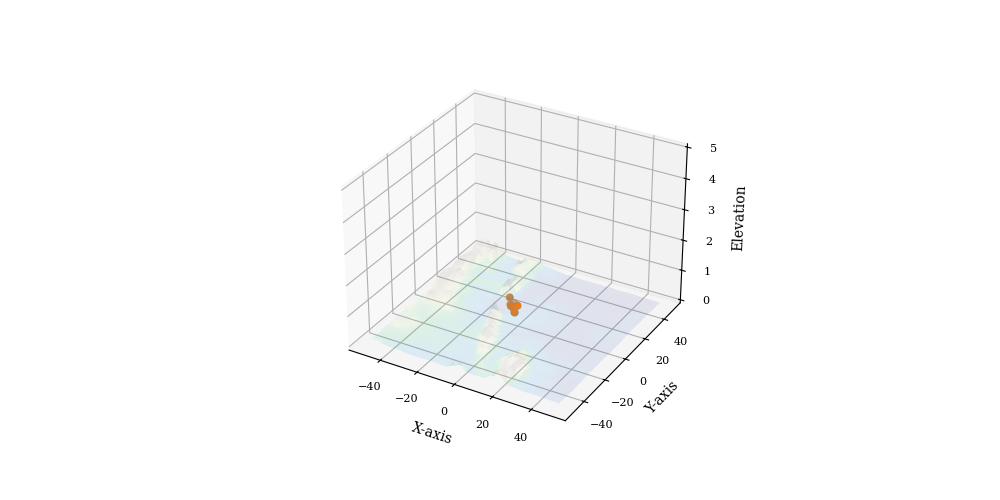

In [33]:
from scipy.ndimage.interpolation import map_coordinates
import matplotlib.colors as mcolors
from scipy import interpolate
import matplotlib.pyplot as plt


%matplotlib widget

    
    
'''
Plot Ground Truth
'''

# plot_samp_pts = True

# Smooth the original heights using a Gaussian filter /OR use interpolation
# smooth_env = gaussian_filter(env, sigma=2)

# new_dims = []
# for original_length, new_length in zip(env.shape, (600,600)):
#     new_dims.append(np.linspace(0, original_length-1, new_length))

# coords = np.meshgrid(*new_dims, indexing='ij')
# smooth_env = map_coordinates(env, coords)

# # Create a meshgrid for X and Y coordinates
xi = np.linspace(-50 , 50, env.shape[0])
yi = np.linspace(-50, 50, env.shape[1])
X, Y = np.meshgrid(xi, yi)

# Create a finer meshgrid for interpolation
# xi = np.linspace(0, env.shape[0], 600)
# yi = np.linspace(0, env.shape[0], 600)
# xi, yi = np.meshgrid(xi, yi)


# xnew, ynew = np.mgrid[-1:1:500j, -1:1:500j]
# tck = interpolate.bisplrep(X, Y, env, s=0)
# znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

# # Interpolate heights
# zi = griddata((x.flatten(), y.flatten()), smooth_env.flatten(), (xi, yi), method='cubic')

# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface
# ax.plot_surface(xnew, ynew, znew, cmap='viridis', alpha=0.5, label='Interpolated Surface')
ax.plot_surface(X,Y,env,cmap='terrain', alpha=0.1, zorder=1)

ax.scatter3D(x_at_start[:,0], x_at_start[:, 1], y_at_start,  'r.', zorder=3)
ax.scatter3D(eval_inputs[index,0], eval_inputs[index, 1], y_at_start,  'b.',  zorder=3)


# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Elevation')
ax.set_zlim([0, 5.0])

plt.show()
    




In [9]:
import time

t0 = time.time()
for i in range(len(eval_inputs)):
    time.sleep(0.033)
    
t1 = time.time()

t1 - t0
    

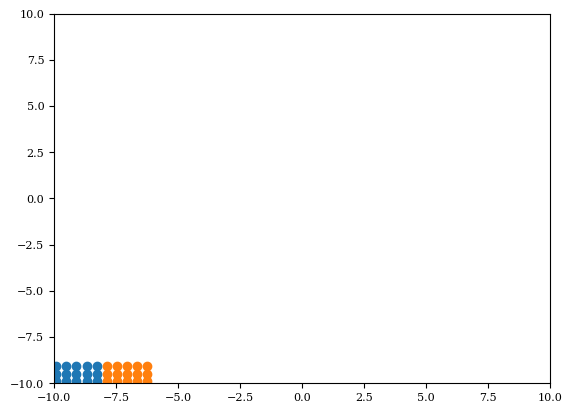

In [ ]:
import matplotlib.pyplot as plt

x_ext, y_ext = cfg.eval_grid

for i in range(2):
    

    subset = np.vstack( [eval_inputs[5*i:5*i + 5], eval_inputs[5*i + x_ext : 5*i + x_ext + 5], eval_inputs[5*i + 2*x_ext: 5*i + 2*x_ext + 5]] )
                       

    plt.scatter(subset[:,0], subset[:,1])
    plt.ylim([-10, 10])
    plt.xlim([-10, 10])

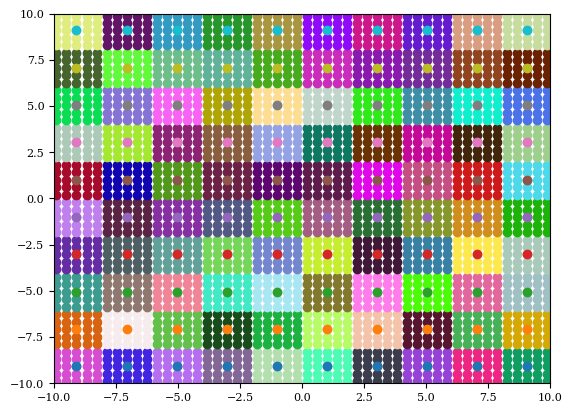

In [ ]:
ws = 5

iters  = int(np.sqrt(eval_inputs.shape[0] / ws**2))

for i in range(iters):
    for j in range(iters):        
        
        subset = np.column_stack((xx[i*ws: (i+1)*ws, i*ws: (i+1)*ws].flatten(), yy[j*ws: (j+1)*ws, j*ws: (j+1)*ws].flatten()))
            
        plt.scatter(subset[:,0], subset[:,1], c=np.random.rand(1,3))
        c_i = int(ws/2) * ws + int(ws/2)
        
        plt.scatter(subset[c_i,0], subset[c_i,1])
        plt.ylim([-10, 10])
        plt.xlim([-10, 10])

In [ ]:
for i in range(10):
    subset = eval_inputs.reshape(50,2,50)[i,:,i]
    plt.scatter(subset[:,0], subset[:,1], c=np.random.rand(1,3))
    # plt.scatter(subset[c_i,0], subset[c_i,1])
    plt.ylim([-10, 10])
    plt.xlim([-10, 10])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [21]:

x_min, x_max, y_min, y_max = cfg.task_extent
x_grid = np.linspace(x_min, x_max, 10)
y_grid = np.linspace(y_min, y_max, 10)
xx, yy = np.meshgrid(x_grid, y_grid)
x_init = np.column_stack((xx.flatten(), yy.flatten()))
y_init = sensor.get(x_init[:, 0], x_init[:, 1]).reshape(-1, 1)


print(f"Collected {len(x_init)} samples in pilot survey.")

Collected 100 samples in pilot survey.


In [25]:
eval_list = list(map(tuple, np.round(eval_inputs, 1)))
len(eval_list)

train_list = list(map(tuple, np.round(x_init,1)))
len(train_list)

test_list = list(filter(lambda x: x not in train_list, eval_list))
len(test_list)

test_env_points = np.array(test_list)

In [26]:
from collections import defaultdict
from sklearn.cluster import KMeans

def assign_points_to_centers(centers, arbitrary_points):
    # Calculate the distance between each arbitrary point and each center point
    distances = np.sqrt(np.sum((arbitrary_points[:, np.newaxis] - centers) ** 2, axis=2))
    
    # Find the index of the closest center point for each arbitrary point
    closest_center_indices = np.argmin(distances, axis=1)
    
    return closest_center_indices

def cluster_points(arbitrary_points, assignments):
    clusters = defaultdict(list)
    for idx, assignment in enumerate(assignments):
        clusters[assignment].append(arbitrary_points[idx])
    return clusters

In [27]:
n_clusters = 30


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_env_points)
cluster_centers = kmeans.cluster_centers_

assignment = assign_points_to_centers(cluster_centers, test_env_points)
clusters = cluster_points(assignments=assignment, arbitrary_points=test_env_points)

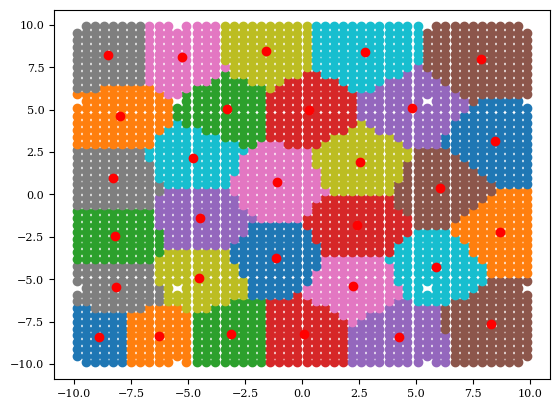

In [32]:
import matplotlib.pyplot as plt

for cluster_idx, points in clusters.items():
    points = np.array(points)
    plt.scatter(points[:,0], points[:,1])
    plt.plot(cluster_centers[cluster_idx,0], cluster_centers[cluster_idx,1], "ro")

### KD-Tree

In [ ]:
import numpy as np
from scipy.spatial import KDTree

tree = KDTree(x_init)

In [ ]:
dd, ii = tree.query(eval_inputs, k=50)

print(dd, ii, sep='\n')


[[ 0.          2.2         2.2        ... 15.55634919 15.86442561
  15.86442561]
 [ 0.40408163  1.79591837  2.23680173 ... 15.50436464 15.52982701
  15.62810186]
 [ 0.80816327  1.39183673  2.34374228 ... 15.24079064 15.42119087
  15.43079565]
 ...
 [ 0.80816327  1.39183673  2.34374228 ... 15.24079064 15.42119087
  15.43079565]
 [ 0.40408163  1.79591837  2.23680173 ... 15.50436464 15.52982701
  15.62810186]
 [ 0.          2.2         2.2        ... 15.55634919 15.86442561
  15.86442561]]
[[ 0 10  1 ... 71 64 46]
 [ 0  1 10 ... 71 46 27]
 [ 0  1 10 ... 27 70 64]
 ...
 [99 98 89 ... 72 29 35]
 [99 98 89 ... 28 53 72]
 [99 89 98 ... 28 35 53]]


In [ ]:
import random

#KD Tree class for Searhing Nearest Neighbor 
class KDTree(object):
    
    """
    This implementation only supports Euclidean distance. 

    The points can be any array-like type, e.g: 
        lists, tuples, numpy arrays.

    Usage:
    1. Make the KD-Tree:
        `kd_tree = KDTree(points, dim)`
    2. You can then use `get_knn` for k nearest neighbors or 
       `get_nearest` for the nearest neighbor

    points are be a list of points: [[0, 1, 2], [12.3, 4.5, 2.3], ...]
    """
    def __init__(self, points, dim, dist_sq_func=None):
        """Makes the KD-Tree for fast lookup.

        Parameters
        ----------
        points : list<point>
            A list of points.
        dim : int 
            The dimension of the points. 
        dist_sq_func : function(point, point), optional
            A function that returns the squared Euclidean distance
            between the two points. 
            If omitted, it uses the default implementation.
        """

        if dist_sq_func is None:
            dist_sq_func = lambda a, b: sum((x - b[i]) ** 2 for i, x in enumerate(a[:2]))
                
        def make(points, i=0):
            if len(points) > 1:
                points.sort(key=lambda x: x[i])
                i = (i + 1) % dim
                m = len(points) >> 1
                return [make(points[:m], i), make(points[m + 1:], i), 
                    points[m]]
            if len(points) == 1:
                return [None, None, points[0]]
        
        def add_point(node, point, i=0):
            if node is not None:
                dx = node[2][i] - point[i]
                for j, c in ((0, dx >= 0), (1, dx < 0)):
                    if c and node[j] is None:
                        node[j] = [None, None, point]
                    elif c:
                        add_point(node[j], point, (i + 1) % dim)

        import heapq
        def get_knn(node, point, k, return_dist_sq, heap, i=0, tiebreaker=1):
            if node is not None:
                dist_sq = dist_sq_func(point, node[2])
                
                dx = node[2][i] - point[i]
                if len(heap) < k:
                    heapq.heappush(heap, (-dist_sq, tiebreaker, node[2]))
                elif dist_sq < -heap[0][0]:
                    heapq.heappushpop(heap, (-dist_sq, tiebreaker, node[2]))
                i = (i + 1) % dim
                # Goes into the left branch, then the right branch if needed
                for b in (dx < 0, dx >= 0)[:1 + (dx * dx < -heap[0][0])]:
                    get_knn(node[b], point, k, return_dist_sq, 
                        heap, i, (tiebreaker << 1) | b)
            if tiebreaker == 1:
                return [(-h[0], h[2]) if return_dist_sq else h[2] 
                    for h in sorted(heap)][::-1]

        def walk(node):
            if node is not None:
                for j in 0, 1:
                    for x in walk(node[j]):
                        yield x
                yield node[2]

        self._add_point = add_point
        self._get_knn = get_knn 
        self._root = make(points)
        self._walk = walk

    def __iter__(self):
        return self._walk(self._root)
        
    def add_point(self, point):
        """Adds a point to the kd-tree.
        
        Parameters
        ----------
        point : array-like
            The point.
        """
        if self._root is None:
            self._root = [None, None, point]
        else:
            self._add_point(self._root, point)

    def get_knn(self, point, k, return_dist_sq=True):
        """Returns k nearest neighbors.

        Parameters
        ----------
        point : array-like
            The point.
        k: int 
            The number of nearest neighbors.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distances.

        Returns
        -------
        list<array-like>
            The nearest neighbors. 
            If `return_dist_sq` is true, the return will be:
                [(dist_sq, point), ...]
            else:
                [point, ...]
        """
        return self._get_knn(self._root, point, k, return_dist_sq, [])

    def get_nearest(self, point, return_dist_sq=True):
        """Returns the nearest neighbor.

        Parameters
        ----------
        point : array-like
            The point.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distance.

        Returns
        -------
        array-like
            The nearest neighbor. 
            If the tree is empty, returns `None`.
            If `return_dist_sq` is true, the return will be:
                (dist_sq, point)
            else:
                point
        """
        l = self._get_knn(self._root, point, 1, return_dist_sq, [])
        return l[0] if len(l) else None

# Helper Functions
def dist_sq_func(a, b):
    return sum((x - b[i]) ** 2 for i, x in enumerate(a))

def get_knn_naive(points, point, k, return_dist_sq=True):
    neighbors = []
    for i, pp in enumerate(points):
        dist_sq = dist_sq_func(point, pp)
        neighbors.append((dist_sq, pp))
    neighbors = sorted(neighbors)[:k]
    return neighbors if return_dist_sq else [n[1] for n in neighbors]

def get_nearest_naive(points, point, return_dist_sq=True):
    nearest = min(points, key=lambda p:dist_sq_func(p, point))
    if return_dist_sq:
        return (dist_sq_func(nearest, point), nearest) 
    return nearest

def rand_point(dim):
    return [random.uniform(-1, 1) for d in range(dim)]

### Voronoi - find border of the clusters

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

--
[[40, 25, 1, 14, 15, 39], [31, 7, 9, 19, 20, 30], [28, 17, 3, 2, 27], [11, 0, 49, 50], [34, 24, 4, 6, 21, 33], [26, 52, 51, 25, 40, 41, 27, 28], [12, 13, 54, 53, 0], [45, 29, 11, 0, 12, 44], [47, 5, 43, 39, 15, 46], [36, 10, 9, 19, 35], [56, 55, 1, 25], [10, 8, 7, 9], [58, 26, 16, 22, 38, 37, 57], [48, 30, 20, 21, 6, 5, 47], [42, 2, 27, 41], [48, 30, 31, 32, 29, 45], [28, 17, 18, 16, 26], [1, 60, 59, 13, 14], [32, 29, 11, 61, 62], [48, 45, 44, 46, 47], [38, 34, 33, 35, 36, 37], [24, 4, 3, 17, 18, 23], [64, 37, 36, 10, 8, 63], [7, 31, 32, 65, 66, 8], [43, 39, 40, 41, 42], [23, 18, 16, 22], [46, 15, 14, 13, 12, 44], [38, 22, 23, 24, 34], [35, 19, 20, 21, 33], [43, 5, 6, 4, 3, 2, 42]]
--
[[ 7.35771673e+00  5.45606280e+00]
 [ 8.52539347e+00 -4.93899658e+00]
 [-1.53308401e+00 -6.25461356e+00]
 [-2.27283527e+00 -5.93091029e+00]
 [-3.25232787e+00 -3.17927055e+00]
 [-6.09263827e-02 -1.51832669e+00]
 [-2.05356438e+00 -1.49476802e+00]
 [-3.34088595e+00  7.18088341e+00]
 [-6.15316439e+00  4.10

(-8.497959183673466, 8.531707317073169)

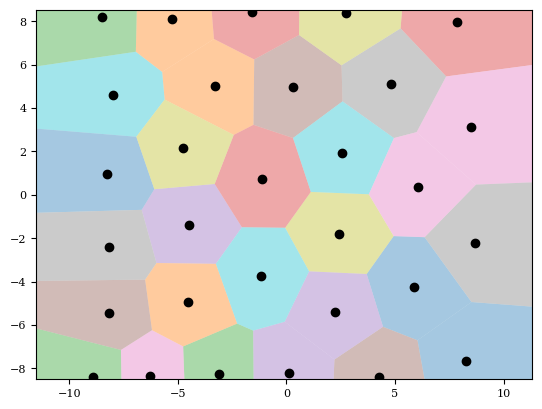

In [34]:
# make up data points
np.random.seed(1234)
points = cluster_centers#np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(points) 

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print("--")
print(regions)
print("--")
print(vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)



In [33]:
vor

6
6
5
4
6
8
5
6
6
5
4
4
7
7
4
6
5
5
5
5
6
6
6
6
5
4
6
5
5
7


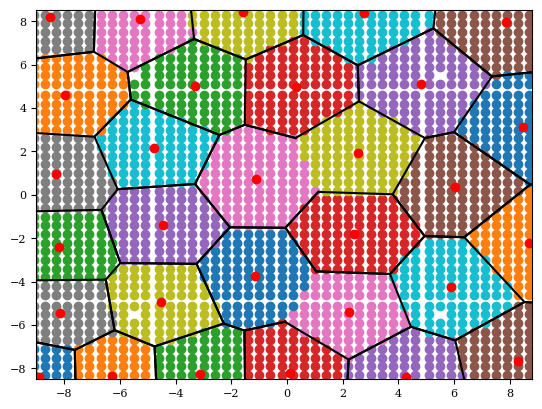

In [46]:

extra_eval_pts = 0

for region in regions:  
    subset = vertices[region]
    plt.plot(subset[:,0], subset[:,1], color='black')
    print(len(subset))
    extra_eval_pts += len(subset)
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

extra_eval_pts

for cluster_idx, points in clusters.items():
    points = np.array(points)
    plt.scatter(points[:,0], points[:,1])
    plt.plot(cluster_centers[cluster_idx,0], cluster_centers[cluster_idx,1], "ro")